# Preparing Data

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pymer4 as pymer4
from statannot import add_stat_annotation

p = 'data/'

# Temporal Binding


## prep
### load data

In [2]:
# load data
behavior_raw = pd.read_csv( p + 'PI_results_design.csv')
# set data types
behavior_raw[['ed','rt', 'rd']] = behavior_raw[['ed','rt', 'rd']].apply(pd.to_numeric, axis=1)
# behavior_raw['rd'] = behavior_raw['rd'].astype("string")  # needs to be string before category for R conversion
# behavior_raw[['rd','condition']] = behavior_raw[['rd','condition']].astype("category")
behavior_raw[['condition']] = behavior_raw[['condition']].astype("category")

### clean data

In [3]:
# bad trials:
# remove rows where control == 'muscle' and condition = 'ems_random'
behavior_raw = behavior_raw.loc[~((behavior_raw['control'] == 'muscle') & (behavior_raw['condition'] == 'ems_random'))]

# remove rows where trial_nr > 30
# behavior_raw = behavior_raw.loc[(behavior_raw['tr_nr'] >= 10) & (behavior_raw['tr_nr'] <= 60)]

# bad subjects:
# delete VP 18 (did not follow instructions in block 3)
behavior_raw =  behavior_raw.loc[behavior_raw["id"] !=18]
# behavior_raw =  behavior_raw.loc[behavior_raw["id"] !=23]

# calculate new variable 'estimate' (rd - ed)
behavior_raw['estimate'] = behavior_raw['ed'] - behavior_raw['rd']

# removes outliers trials that have outliers either in rt or ed
cols = ['rt', 'estimate', 'delta_tap_ems'] # relevant cols

# calculate quantiles and IQR
Q1 = behavior_raw[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = behavior_raw[cols].quantile(0.75)
IQR = Q3 - Q1

# return a boolean array of the rows with (any) non-outlier column values
condition = ~((behavior_raw[cols] < (Q1 - 1.5 * IQR)) | (behavior_raw[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# filter our dataframe based on condition
behavior = behavior_raw[condition]
behavior_del = behavior_raw[-condition]

behavior_grouped = behavior.groupby(['id','condition','control'])['estimate'].mean().reset_index()
behavior_grouped = behavior_grouped.loc[~((behavior_grouped['control'] == 'muscle') & (behavior_grouped['condition'] == 'ems_random'))]
behavior_grouped = behavior_grouped.loc[~((behavior_grouped['control'] == 'ems') & (behavior_grouped['condition'] == 'baseline'))]

# behavior_grouped
# rename conditions to intention, involuntary, augmented
behavior_grouped['condition'] = behavior_grouped['condition'].replace({'baseline': 'intention', 'ems_random': 'involuntary', 'ems_bci': 'augmented'})

behavior_grouped


,id,condition,control,estimate
1,12,intention,muscle,-154.285714
2,12,augmented,ems,-220.270270
3,12,augmented,muscle,-135.625000
4,12,involuntary,ems,-153.230769
7,14,intention,muscle,-190.400000
8,14,augmented,ems,-325.098039
9,14,augmented,muscle,-332.222222
10,14,involuntary,ems,-317.253521
13,15,intention,muscle,-58.235294
14,15,augmented,ems,-30.000000


In [4]:
# check outlier removel

#count deleted trials
print('Deleted trials:',len(behavior_del))

#per pID
print('Deleted trials per pID')
print(behavior_del['id'].value_counts())

print('mean')
print(behavior_del['id'].value_counts().mean())
print('sd')
print(behavior_del['id'].value_counts().std())

#per condition
print('Deleted trials per condition')
print(behavior_del['condition'].value_counts())
print('mean')
print(behavior_del['condition'].value_counts().mean())
print('sd')
print(behavior_del['condition'].value_counts().std())

print(len(behavior))

Deleted trials: 296
Deleted trials per pID
id
15    84
19    83
23    34
16    27
17    25
12    21
14    10
20     8
22     4
Name: count, dtype: int64
mean
32.888888888888886
sd
30.292096512310124
Deleted trials per condition
condition
ems_random    153
baseline       76
ems_bci        67
Name: count, dtype: int64
mean
98.66666666666667
sd
47.26873526268005
1946


In [ ]:
#check cleaned data

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'rt',ax =ax, hue = 'id')
#ax.set_xlim(0,5) # remove outliers for visualization

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'estimate',ax =ax, hue = 'id')

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'delta_tap_ems',ax =ax, hue = 'id')


## plot
### prep plot

In [5]:
# with stimulation condition + time condition+ rd as y
# behavior[['rd']] = behavior[['rd']].apply(pd.to_numeric, axis=1)
# behavior[['ed']] = behavior[['ed']].apply(pd.to_numeric, axis=1)
# diff = ed - 350 because 350 is the mean of the different time intervals; maybe add *-1  to adapt direction of the plot
# behavior["diff"]= behavior['ed']
# behavior[['rd']] = behavior[['rd']].astype("category")

# behavior_means = behavior.groupby(['id','condition'],as_index=False)['diff'].mean()

palette = ['#576683', '#E4f392', '#337775']
cats= ['intention','involuntary','augmented'] 

ylabel = 'estimated delay'
xlabel = 'condition'
title = 'temporal_binding_all_conditions'
data = behavior_grouped
data_means = behavior_grouped
y = 'estimate'
x = "condition"
hue = "id"
hue2 = 'rd'

### plot

/var/folders/04/2q4w_vgn0_7dtkxyll6j2gx40000gn/T/ipykernel_96340/3036099530.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data = data,x = x, y = y,  order= ['intention','involuntary','augmented'] ,  palette= palette, width=.4 )
/var/folders/04/2q4w_vgn0_7dtkxyll6j2gx40000gn/T/ipykernel_96340/3036099530.py:32: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(data = data_means, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)


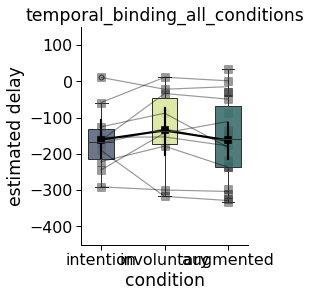

In [6]:
# runs plot but needs post processing in affinty desiger
cats_0 = data[data[x]==cats[0]]
cats_1 = data[data[x]==cats[1]]
cats_2 = data[data[x]==cats[2]]

pairs = [(cats[0], cats[1],cats[2])]

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(3,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    # Plot the orbital period with horizontal boxes
    # sns.boxplot(x=x, y=y, data=data, whis=[0, 100], width=.3, order= ['intention','involuntary','augmented'], palette=palette, linewidth=1)

    # Add in points to show each observation
    # sns.stripplot(x=x, y=y, data=data, size=6, palette=palette, linewidth=1, dodge='auto', legend=None)

    # show boxplots
    ax = sns.boxplot(data = data,x = x, y = y,  order= ['intention','involuntary','augmented'] ,  palette= palette, width=.4 )
    for patch in ax.patches: # adapt alpha
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .9))

    # show line connecting means
    ax =  sns.pointplot(data = data,x = x, y = y, markers="s" ,color = 'black', order = cats)
    
    #  show lines connecting pid means observations    
    ax = sns.lineplot(data = data_means, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)
    
    ax = sns.scatterplot(data=data_means, x=x, y=y,s=50, legend= True, marker="s",color = 'black',edgecolor = 'black',alpha=0.4)
        
    # ax.invert_yaxis()
    # add_stat_annotation(ax, data=data_means, x=x, y=y, box_pairs=[("baseline", "ems_random"), ("baseline", "ems_bci"), ('ems_random', 'ems_bci')], test='t-test_paired', text_format='star', loc='outside', verbose=2)

    handles, labels = ax.get_legend_handles_labels()  
    
    #plt.legend(handles[3:6],labels[3:6],frameon=True,loc = 'upper left',labelspacing =0.3)

    # set ylimit
    ax.set_ylim(-450,150)
    
    # label_plot_for_subcats(ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    plt.show()

# fig.savefig('results/'+title + '_'+'.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig('results/'+title + '_'+'.svg', format='svg', transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig('results/'+title + '_' +'.png', format='png', transparent=True, bbox_inches='tight', dpi=300)

In [ ]:
# drop conditions intention and involuntary from data
data = data.loc[data['condition'] != 'intention']
data = data.loc[data['condition'] != 'involuntary']

# drop id 23 from data
data = data.loc[data['id'] != 23]
print(data.groupby('control')['estimate'].agg(['mean','std']))

# print summary of data

palette = ['#E4f392','#576683', '#337775']
cats= ['ems','muscle'] 

ylabel = ''
xlabel = 'augmented'
title = ''
data = data
data_means = data
y = 'estimate'
x = "control"
hue = "id"
hue2 = 'rd'

# runs plot but needs post processing in affinty desiger
cats_0 = data[data[x]==cats[0]]
cats_1 = data[data[x]==cats[1]]

pairs = [(cats[0], cats[1])]

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    # fig, ax = plt.subplots(1, 1, figsize=(2,4))
    fig, ax = plt.subplots(figsize=(3, 4))
    # fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    # Plot the orbital period with horizontal boxes
    sns.boxplot(x=x, y=y, data=data, whis=[0, 100], width=.3, palette=palette, linewidth=1)

    # Add in points to show each observation
    # sns.stripplot(x=x, y=y, data=data, size=6, palette=palette, linewidth=1, dodge='auto', legend=None)
    
    # ax = sns.boxplot(data = data,x = x, y = y,  order= ['intention','involuntary','augmented'] ,  palette= palette )
    # ax = sns.boxplot(data = data,x = x, y = y,  palette= palette, width=.4)
    for patch in ax.patches: # adapt alpha
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .9))

    # show line connecting means
    ax = sns.pointplot(data = data,x = x, y = y, markers="s" ,color = 'black', order = cats)
    
    #  show lines connecting pid means observations    
    ax = sns.lineplot(data = data_means, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)
    
    ax = sns.scatterplot(data=data_means, x=x, y=y,s=50, legend= True, marker="s",color = 'black',edgecolor = 'black',alpha=0.4)
        
    # ax.invert_yaxis()
    # add_stat_annotation(ax, data=data_means, x=x, y=y, box_pairs=[("baseline", "ems_random"), ("baseline", "ems_bci"), ('ems_random', 'ems_bci')], test='t-test_paired', text_format='star', loc='outside', verbose=2)

    handles, labels = ax.get_legend_handles_labels()  
    
    #plt.legend(handles[3:6],labels[3:6],frameon=True,loc = 'upper left',labelspacing =0.3)

    # set ylimit
    ax.set_ylim(-450,150)
    
    # label_plot_for_subcats(ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    # plt.tight_layout()
    plt.show()

fig.savefig('results/'+title + '_'+'.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)
fig.savefig('results/'+title + '_'+'.svg', format='svg', transparent=True, bbox_inches='tight', dpi=300)
fig.savefig('results/'+title + '_' +'.png', format='png', transparent=True, bbox_inches='tight', dpi=300)

## Analysis


### descriptive

In [7]:
print(behavior_grouped.groupby('condition')['estimate'].agg(['mean','std']))

                   mean         std
condition                          
intention   -160.657790   88.109816
augmented   -162.419347  113.840786
involuntary -135.268674  110.315753


### LMM

#### prep
- switched from rpy2 to pymer4, because it is less annoying with importing / exporting from python to R
- not sure if of this is still necessary, but since pymer4 is based on rpy2, this might be the case

In [ ]:
# packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
# from rpy2.robjects.packages import importr
# from rpy2.robjects.vectors import StrVector
# utils = importr("utils")
# utils.chooseCRANmirror(ind=1)

In [ ]:
# packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot', 'Matrix')
# from rpy2.robjects.vectors import StrVector
# utils.install_packages(StrVector(packnames))

#### built models

In [8]:
# remove id 23
behavior_grouped = behavior_grouped.loc[behavior_grouped["id"] !=23]
# variable condition as factor

In [9]:
from pymer4.models import Lmer

In [10]:
# aggregate behavior over id and condition
# behavior_means = behavior.groupby(['id','condition'],as_index=False)['ed'].mean()

full_model = Lmer("estimate ~ condition + (1|id)", data = behavior_grouped)
display(full_model.fit(REML = False))

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: estimate~condition+(1|id)

Family: gaussian	 Inference: parametric

Number of observations: 36	 Groups: {'id': 9.0}

Log-likelihood: -199.186 	 AIC: 408.372

Random effects:

                 Name       Var     Std
id        (Intercept)  9032.123  95.037
Residual               1731.576  41.612

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-160.454,-228.235,-92.673,34.583,11.567,-4.640,0.001,***
conditionaugmented,-8.279,-41.575,25.017,16.988,27.000,-0.487,0.630,
conditioninvoluntary,13.860,-24.587,52.307,19.616,27.000,0.707,0.486,


In [44]:
# full model
# full_model = Lmer("diff ~ condition * rd + (condition|id) + (rd|id)", data = behavior)
# display(full_model.fit(REML = False, factors={"condition": ["baseline", "ems_random", "ems_bci"]}))
# full_model.plot_summary()


#### define null models

In [11]:
# null model without stimulation condition 
null_model = Lmer("estimate ~ (1|id)", data = behavior_grouped)
display(null_model.fit(REML = False))

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: estimate~(1|id)

Family: gaussian	 Inference: parametric

Number of observations: 36	 Groups: {'id': 9.0}

Log-likelihood: -200.011 	 AIC: 406.022

Random effects:

                 Name       Var     Std
id        (Intercept)  9004.843  94.894
Residual               1840.697  42.903

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-161.128,-224.689,-97.568,32.429,9.0,-4.969,0.001,***


#### likelihood ratio tests

stimulation condition

In [12]:
pymer4.stats.lrt([null_model,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,estimate~(1|id),3,406.021736,410.772293,-200.010868,400.021736,,,,
1,estimate~condition+(1|id),5,408.371694,416.289289,-199.185847,398.371694,1.650042,2.0,0.438226,


#### post hoc test

In [61]:
# post hoc test condition
# marginal_estimates, comparisons = full_model.post_hoc(
    # marginal_vars="condition", p_adjust = "bonf")
# print(comparisons)

In [ ]:
# select only augmented
behavior_augmented = behavior_grouped.loc[behavior_grouped['condition'] == 'augmented']

# summary
print(behavior_augmented.groupby('control')['estimate'].agg(['mean','std']))

# paired ttest for condition baseline vs ems_random
ttest = stats.ttest_rel(behavior_augmented.loc[behavior_augmented['control'] == 'muscle']['estimate'], behavior_augmented.loc[behavior_augmented['control'] == 'ems']['estimate'])
print(ttest)

# Questionnaire



In [13]:
questionaire = pd.read_excel(p + 'questionaire.xlsx') 

good_pid = ['12', '14', '15', '16', '17', '19', '20', '21', '22', '23']
questionaire['pID'] = questionaire['pID'].astype(str)
questionaire = questionaire.loc[questionaire['pID'].isin(good_pid)]
questionaire_long = questionaire.melt(id_vars= ['pID'],value_vars=['baseline','passive','agency'])

# rename columns baseline = intention, passive = involuntary, agency = augmented
questionaire_long['variable'] = questionaire_long['variable'].replace({'baseline': 'intention', 'passive': 'involuntary', 'agency': 'augmented'})

### plot control

In [14]:
palette = ['#576683', '#E4f392', '#337775']
ylabel = 'level of control'
xlabel = ''
title = ''
data = questionaire_long
y = 'value'
x = 'variable'
hue = 'pID'

/var/folders/04/2q4w_vgn0_7dtkxyll6j2gx40000gn/T/ipykernel_96340/3041234101.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data = data, x = x, y = y,  palette= palette)
/var/folders/04/2q4w_vgn0_7dtkxyll6j2gx40000gn/T/ipykernel_96340/3041234101.py:21: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(data = data, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False)


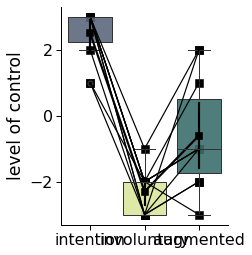

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [15]:
with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(3,4))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True
         # show boxplots
        ax = sns.boxplot(data = data, x = x, y = y,  palette= palette)
        for patch in ax.patches: # adapt alpha
             r, g, b, a = patch.get_facecolor()
             patch.set_facecolor((r, g, b, .9))

                   
        # show line connecting means
        sns.pointplot(
            data = data,x = x, y = y, markers="s", color = 'black')
        
        # pId means
        
        ax = sns.lineplot(data = data, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False)
    
        ax = sns.scatterplot(data=data, x=x, y=y,s=50, legend= True, marker="s",color = 'black',edgecolor = 'black')

        #sns.scatterplot(data = data,x = x, y = y, markers="^",color = 'black')
        # add_stat_annotation(ax, data=data, x=x, y=y, box_pairs=[("baseline", "passive"), ("baseline", "agency"), ('passive', 'agency')], test='t-test_ind', text_format='star', loc='outside', verbose=2)
        
        # Label and show
        # label_plot_for_subcats(ax)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

        plt.show()
        fig.savefig('results/'+title + '_' +'.svg', format='svg', transparent=True, bbox_inches='tight', dpi=300)
        fig.savefig('results/'+title + '_' +'.png', format='png', transparent=True, bbox_inches='tight', dpi=300)
        fig.savefig('results/'+title + '_'+'.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

#### LME


In [16]:
#full model
full_model = Lmer('value ~ variable + (1|pID)', data = questionaire_long)
display(full_model.fit(REML = False))

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: value~variable+(1|pID)

Family: gaussian	 Inference: parametric

Number of observations: 30	 Groups: {'pID': 10.0}

Log-likelihood: -45.384 	 AIC: 100.768

Random effects:

                 Name    Var    Std
pID       (Intercept)  0.190  0.436
Residual               1.043  1.021

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.6,-1.288,0.088,0.351,28.641,-1.708,0.098,.
variableintention,3.1,2.205,3.995,0.457,20.000,6.786,0.000,***
variableinvoluntary,-1.7,-2.595,-0.805,0.457,20.000,-3.722,0.001,**


In [17]:
#null model
null_model = Lmer('value ~ (1|pID)', data = questionaire_long)
null_model.fit(REML = False, summarize=False)

boundary (singular) fit: see help('isSingular') 



In [18]:
# liklyhood ratio test
pymer4.stats.lrt([null_model,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,value~(1|pID),3,140.493331,144.696923,-67.246665,134.493331,,,,
1,value~variable+(1|pID),5,100.767751,107.773738,-45.383875,90.767751,43.72558,2.0,0.0,***


In [19]:
# post hoc test condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="variable",p_adjust = "bonf")

print(comparisons)

ValueError: grouping_vars are required with a continuous marginal_vars

In [ ]:
# participants
print(questionaire.age.mean())
print(questionaire.age.std())

# EEG

In [ ]:
slope = pd.read_csv( p + 'PI_results_design_slope_processed.csv')
#data cleaning happend somewhere else

In [ ]:
palette = ['#576683', '#337775']
cats= ['idle', 'pre_move']
ylabel = 'slope'
xlabel = 'condition'
title = 'slope'
data = slope
y = 'slopes'
x = 'condition'
hue = 'id'

In [ ]:
# plot a box plot of the slope values by condition
#slope.boxplot(column=['slopes'], by=['condition'], figsize=(12,8))

with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(3,4))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True
         # show boxplots
        ax = sns.boxplot(data = data, x = x, y = y,  palette= palette)
        for patch in ax.patches: # adapt alpha
             r, g, b, a = patch.get_facecolor()
             patch.set_facecolor((r, g, b, .9))

                   
        # show line connecting means
        sns.pointplot(data = data,x = x, y = y, markers="s" ,color = 'black')
        
        # pId means
        
        ax = sns.lineplot(data = data, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)
    
        ax = sns.scatterplot(data=data, x=x, y=y,s=10, legend= True, marker="s",color = 'black',edgecolor = 'black',alpha=0.4)

        #sns.scatterplot(data = data,x = x, y = y, markers="^",color = 'black')

        plt.gca().invert_yaxis()

        # add statannotation for the pair 'idle' and 'pre_move'
        add_stat_annotation(ax, data=data, x=x, y=y, box_pairs=[("idle", "pre_move")], test='t-test_ind', text_format='star', loc='outside', verbose=2)
        

        # Label and show
        # label_plot_for_subcats(ax)
        # ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

      

        plt.show()
        fig.savefig('results/'+title + '_' +'.svg', format='svg', transparent=True, bbox_inches='tight', dpi=300)
        fig.savefig('results/'+title + '_' +'.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)
        fig.savefig('results/'+title + '_' +'.png', format='png', transparent=True, bbox_inches='tight', dpi=300)

In [ ]:
stats.ttest_ind(slope['slopes'][slope['condition'] == 'idle'], slope['slopes'][slope['condition'] == 'pre_move'])